In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

#### pystan windows C++ compiler

* conda install libpython m2w64-toolchain -c msys2 --yes 

In [2]:
import os
import platform
import pystan

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")

### pystan leveraged by fbprophet need to test before using kats
if not dependencies_installed:
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

#### Overview of MetaLearning Framework

[research paper]( https://arxiv.org/pdf/2102.05740.pdf)

In [3]:
import pandas as pd
import numpy as np
from kats.consts import TimeSeriesData
import matplotlib.pyplot as plt

def retrieve_example_url(csv_name):
    url_path = f'https://raw.githubusercontent.com/facebookresearch/Kats/master/kats/data/{csv_name}.csv'
    return url_path

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
from kats.models.metalearner.get_metadata import GetMetaData

air_passengers_df = pd.read_csv(retrieve_example_url(csv_name='air_passengers'))
air_passengers_df.columns = ['time','value']
air_passengers_ts = TimeSeriesData(air_passengers_df)
error_metric = 'mape'
MD = GetMetaData(data=air_passengers_ts,error_method=error_metric)
MD.all_models
# MD.all_params

INFO:root:We are using the default tune_executor for hyper-param tuning!
INFO:root:Valid time series data!
INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.


{'arima': kats.models.arima.ARIMAModel,
 'holtwinters': kats.models.holtwinters.HoltWintersModel,
 'prophet': kats.models.prophet.ProphetModel,
 'theta': kats.models.theta.ThetaModel,
 'stlf': kats.models.stlf.STLFModel,
 'sarima': kats.models.sarima.SARIMAModel}

In [6]:
air_passengers_metadata = MD.get_meta_data()

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:kats.utils.time_series_parameter_tuning:Parameter tuning search space dimensions: [{'name': 'p', 'type': 'choice', 'values': [1, 2, 3, 4, 5], 'value_type': 'int', 'is_ord

In [13]:
print(air_passengers_metadata.keys())
print(f"search method: {air_passengers_metadata['search_method']}")
print(f"error_method: {air_passengers_metadata['error_method']}")
print(air_passengers_metadata['hpt_res'].keys())
print(air_passengers_metadata['hpt_res']['arima'])
metadata_methods = list(air_passengers_metadata['hpt_res'].keys())
print(sorted(metadata_methods,key=lambda m: air_passengers_metadata['hpt_res'][m][1]))
print(air_passengers_metadata['best_model'])

dict_keys(['hpt_res', 'features', 'best_model', 'search_method', 'error_method'])
search method: RandomSearch
error_method: mape
dict_keys(['arima', 'holtwinters', 'prophet', 'theta', 'stlf', 'sarima'])
({'p': 3, 'd': 1, 'q': 3}, 0.09310859426690006)
['stlf', 'prophet', 'holtwinters', 'theta', 'arima', 'sarima']
stlf


In [18]:
def change_format(tmp):
    tmp['hpt_res']=eval(tmp['hpt_res'])
    tmp['hpt_res']['sarima'][0]['seasonal_order']=eval(tmp['hpt_res']['sarima'][0]['seasonal_order'])
    tmp['features']=eval(tmp['features'])
    return tmp
metadata_df = pd.read_csv(retrieve_example_url(csv_name='m3_meta_data'))
metadata_df = metadata_df.apply(change_format,axis=1)
metadata_list = metadata_df.to_dict(orient='records')
metadata_df.head()

,hpt_res,features,best_model,search_method,error_method,idx
0,"{'arima': ({'p': 5, 'd': 2, 'q': 5}, 0.8932924...","{'length': 68, 'mean': 0.35392156862745106, 'v...",stlf,RandomSearch,mape,N1402
1,"{'arima': ({'p': 5, 'd': 2, 'q': 1}, 0.3989958...","{'length': 68, 'mean': 0.19995256166982928, 'v...",arima,RandomSearch,mape,N1403
2,"{'arima': ({'p': 1, 'd': 2, 'q': 3}, 0.2519500...","{'length': 68, 'mean': 0.48962530217566486, 'v...",holtwinters,RandomSearch,mape,N1404
3,"{'arima': ({'p': 2, 'd': 1, 'q': 3}, 0.3146896...","{'length': 68, 'mean': 0.2980870396939263, 'va...",stlf,RandomSearch,mape,N1405
4,"{'arima': ({'p': 3, 'd': 1, 'q': 1}, 0.1448053...","{'length': 68, 'mean': 0.5336050082683677, 'va...",arima,RandomSearch,mape,N1406


In [21]:
from kats.models.metalearner.metalearner_predictability import MetaLearnPredictability

metalearnpred = MetaLearnPredictability(metadata_list,threshold=0.2)
metalearnpred.train()
metalearnpred.pred(air_passengers_ts)
pkl_name = 'metalearnpred.pkl'
metalearnpred.save_model(pkl_name)

INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.
INFO:root:Successfully save the model: metalearnpred.pkl.


In [23]:
metalearnpred2 = MetaLearnPredictability(load_model=True)
metalearnpred2.load_model(pkl_name)
metalearnpred2.pred(air_passengers_ts)

INFO:root:Initialize this class without meta data, and a pretrained model should be loaded using .load_model() method.
INFO:root:Successfully load the model: metalearnpred.pkl.
INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.


True

INFO:root:No significant data imbalance problem, no need to do downsampling.
INFO:root:Successfully applied random downsampling!
INFO:root:Successfully scaled data by centering to the mean and component-wise scaling to unit variance!


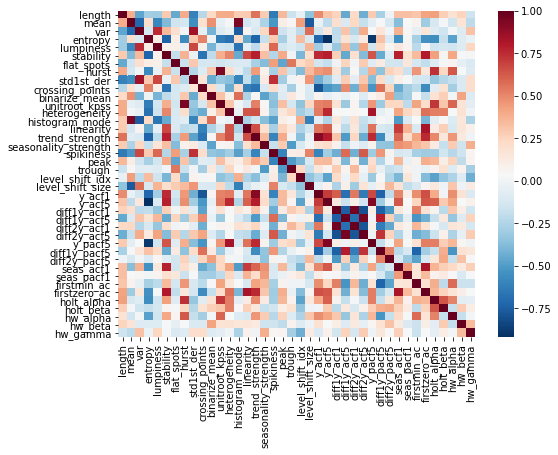

In [25]:
from kats.models.metalearner.metalearner_modelselect import MetaLearnModelSelect

metalearnms = MetaLearnModelSelect(metadata_list)
metalearnms.count_category()
metalearnms.preprocess(downsample=True,scale=True)
metalearnms.plot_corr_heatmap()

In [27]:
results = metalearnms.train()
results_df = pd.DataFrame([results['fit_error'],results['pred_error']])
results_df['error_type']=['fit_error','pred_error']
results_df['error_metric']='MAPE'
results_df

,meta-learn,stlf,arima,holtwinters,prophet,sarima,theta,error_type,error_metric
0,0.279863,0.330968,0.495929,0.421845,0.386934,0.346878,0.387359,fit_error,MAPE
1,0.255092,0.411442,0.273190,0.393907,0.289961,0.250646,0.391525,pred_error,MAPE


In [28]:
metalearnms.pred(air_passengers_ts)
metalearnms_pkl_name = 'metalearnms.pkl'
metalearnms.save_model(metalearnms_pkl_name)
metalearnms2 = MetaLearnModelSelect(load_model=True)
metalearnms2.load_model(metalearnms_pkl_name)
metalearnms2.pred(air_passengers_ts)

INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.
INFO:root:Successfully saved the trained model!
INFO:root:Successfully loaded a pre-trained model!
INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.


'stlf'

#### Hyperparameter Tuning with MetaLearnHPT

In [30]:
metadata_features_df = pd.DataFrame(metadata_df['features'].tolist())
metadata_features_df.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,68,0.353922,0.045430,0.833179,0.000461,0.011440,2,0.067969,0.138205,32,...,5.088309,0.212199,0.071177,1,12,0.126924,0.000000,2.328909e-01,0.000000e+00,0.186695
1,68,0.199953,0.027798,0.899969,0.000377,0.001403,3,0.031521,0.113224,33,...,1.407981,-0.085866,-0.060512,1,3,0.034220,0.032252,1.052632e-01,1.052632e-01,0.263158
2,68,0.489625,0.045509,0.806731,0.000044,0.014501,2,-0.040535,0.129866,24,...,1.342792,0.173154,-0.019452,2,18,0.044327,0.044327,1.052632e-01,1.052632e-01,0.210526
3,68,0.298087,0.049313,0.667211,0.000149,0.026464,1,0.021439,0.094965,25,...,1.676189,0.330326,-0.217522,3,23,0.000007,0.000000,5.263158e-02,5.263158e-02,0.157895
4,68,0.533605,0.065904,0.823098,0.000124,0.021781,2,-0.045258,0.152166,21,...,1.469424,0.207897,0.014251,2,22,0.000064,0.000000,7.091354e-10,9.692337e-12,0.000000


In [31]:
metadata_hpt_df = pd.DataFrame(metadata_df['hpt_res'].map(lambda x: x['holtwinters'][0]).tolist())
metadata_hpt_df.head()

,seasonal_periods,trend,damped,seasonal
0,7,additive,True,multiplicative
1,7,multiplicative,True,multiplicative
2,14,additive,True,additive
3,4,multiplicative,False,multiplicative
4,10,multiplicative,False,additive


In [36]:
from kats.models.metalearner.metalearner_hpt import MetaLearnHPT
mlhpt_holtwinters = MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,
    default_model='holtwinters'
)
mlhpt_holtwinters2 = MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,
    categorical_idx=['trend','damped','seasonal'],
    numerical_idx=['seasonal_periods']
)
# MetaLearnJpy builds a neural network
mlhpt_holtwinters.build_network()
mlhpt_holtwinters.train(lr=0.001,batch_size=20)

INFO:root:Default neural network for model holtwinters is built.


Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=20, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=2, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=6, bias=True)
    )
  )
  (num_layer): ModuleList()
)


INFO:root:Early stopping! Stop at epoch 83.


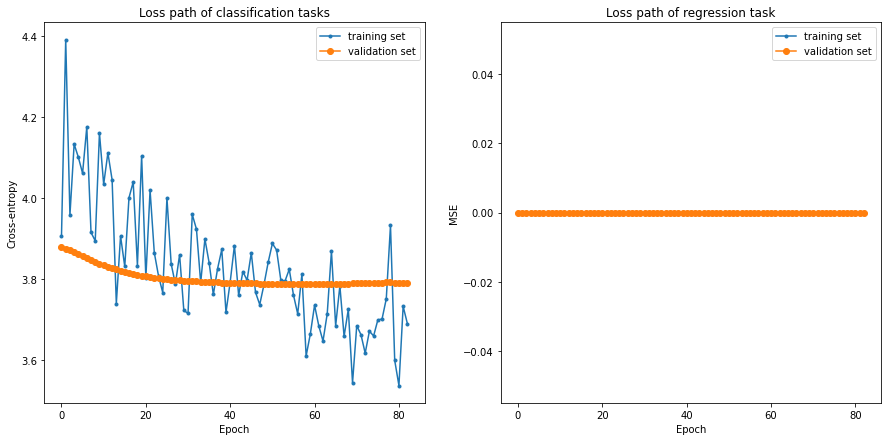

In [37]:
mlhpt_holtwinters.plot()

In [38]:
mlhpt_pred = mlhpt_holtwinters.pred(air_passengers_ts)
print(mlhpt_pred['parameters'].iloc[0])
mlhpt_hw_pkl_name = 'mlhpt_hw.pkl'
mlhpt_holtwinters.save_model(mlhpt_hw_pkl_name)
mlhpt_holtwinters3=MetaLearnHPT(load_model=True)
mlhpt_holtwinters3.load_model(mlhpt_hw_pkl_name)
mlhpt3_pred = mlhpt_holtwinters3.pred(air_passengers_ts)
mlhpt3_pred['parameters'].iloc[0]

INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.
INFO:root:Successfully saved the trained model!
INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.


{'trend': 'multiplicative', 'damped': False, 'seasonal': 'multiplicative', 'seasonal_periods': 4}


{'trend': 'multiplicative',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 4}

In [39]:
mlhpt_holtwinters2.build_network(
    n_hidden_shared=[50],
    n_hidden_cat_combo=[[20,10],[20,10],[20]],
    n_hidden_num=[30]
)

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (num_layer): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [40]:
mlhpt_holtwinters2.train(
    loss_scale=30,
    lr=0.005,
    n_epochs=2000,
    batch_size=16,
    method='SGD', # currently SGD and ADAM supported
    momentum=0,
    n_epochs_stop=50
)

INFO:root:Early stopping! Stop at epoch 163.


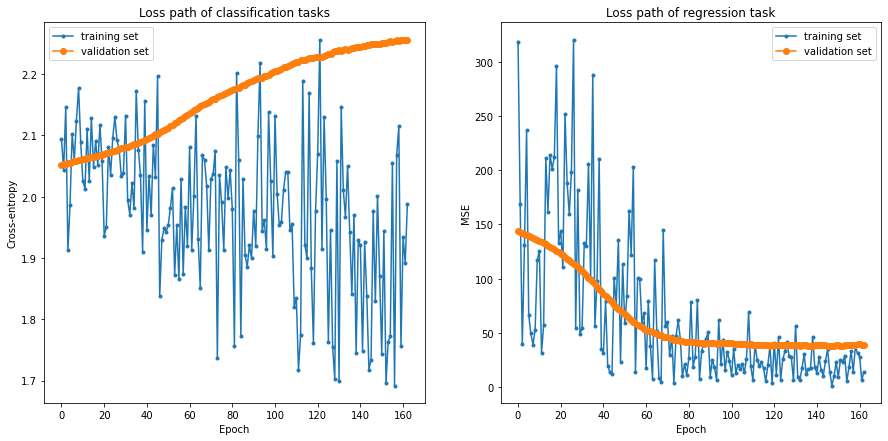

In [41]:
mlhpt_holtwinters2.plot()

In [42]:
mlhpt2_pred = mlhpt_holtwinters2.pred(air_passengers_ts)
mlhpt2_pred['parameters'].iloc[0]

INFO:root:Successful scaled! Each value of TS has been divided by the max value of TS.


{'trend': 'additive',
 'damped': True,
 'seasonal': 'multiplicative',
 'seasonal_periods': 122.97086}